In [1]:
using Pkg
pkg"activate ."
pkg"add MLDatasets MLDataUtils LinearAlgebra Images StatsBase https://github.com/sadit/KCenters.jl https://github.com/sadit/SimilaritySearch.jl"
using MLDatasets, MLDataUtils, LinearAlgebra, Images, StatsBase, KCenters, SimilaritySearch

Activating environment at `~/Research/KCenters.jl/tutorials/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/sadit/KCenters.jl`
  Updating git-repo `https://github.com/sadit/KCenters.jl`
  Updating git-repo `https://github.com/sadit/SimilaritySearch.jl`
  Updating git-repo `https://github.com/sadit/SimilaritySearch.jl`
 Resolving package versions...
  Updating `~/Research/KCenters.jl/tutorials/Project.toml`
  [053f045d] ~ SimilaritySearch v0.3.14 #master (https://github.com/sadit/SimilaritySearch.jl)
  Updating `~/Research/KCenters.jl/tutorials/Manifest.toml`
  [053f045d] ~ SimilaritySearch v0.3.14 #master (https://github.com/sadit/SimilaritySearch.jl)


┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/MLDataUtils/CQWB9.ji for MLDataUtils [cc2ba9b6-d476-5e6d-8eaf-a92d5412d41d]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/KCenters/KuFpR.ji for KCenters [5d8de97f-65f8-4dd6-a15b-0f89c36a43ce]
└ @ Base loading.jl:1240


(method = "kcenters m=100", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l1_distance, acc = 0.9009)

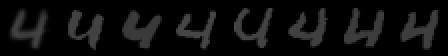

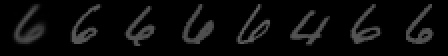

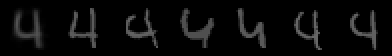

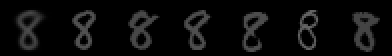

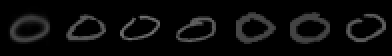

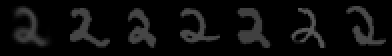

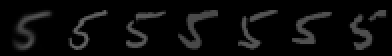

199.161588 seconds (1.47 M allocations: 1.889 GiB, 0.34% gc time)


(method = "kcenters m=100", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l2_distance, acc = 0.9244)

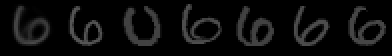

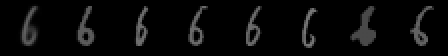

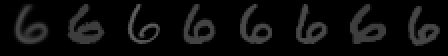

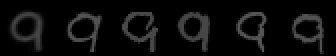

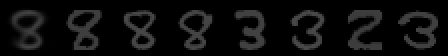

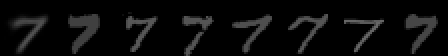

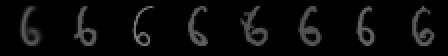

134.299368 seconds (685.64 k allocations: 1.305 GiB, 0.27% gc time)


(method = "kcenters m=100", kernel = KCenters.relu_kernel, dist = SimilaritySearch.cosine_distance, acc = 0.9194)

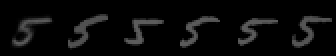

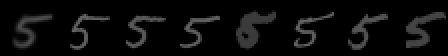

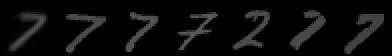

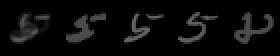

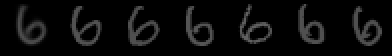

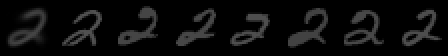

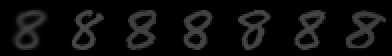

 89.696007 seconds (549.62 k allocations: 959.132 MiB, 0.15% gc time)
 

(method = "kcenters by label", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l1_distance, acc = 0.6812)

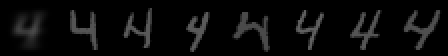

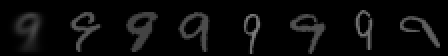

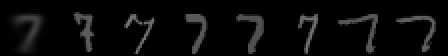

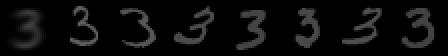

 0.108244 seconds (60.09 k allocations: 187.800 MiB, 36.67% gc time)
 

(method = "kcenters by label", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l2_distance, acc = 0.7874)

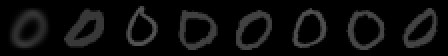

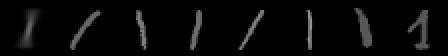

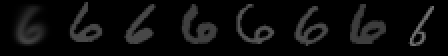

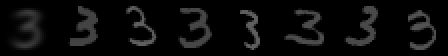

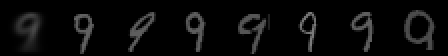

 0.095827 seconds (60.09 k allocations: 187.800 MiB, 33.09% gc time)


(method = "kcenters by label", kernel = KCenters.relu_kernel, dist = SimilaritySearch.cosine_distance, acc = 0.7562)

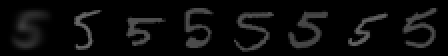

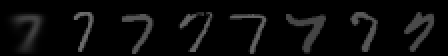

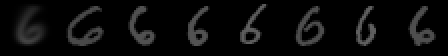

  0.084959 seconds (60.09 k allocations: 187.800 MiB, 24.32% gc time)


In [5]:
#const new_size=(9, 9)
#const new_size = (16, 16)
const new_size = (28, 28)
const new_length = reduce(*, new_size)


function normalize_vector(X, i)
    v = @view X[:, :, i]
    if new_size[1] != 28
        v = imresize(v, new_size)       
    end
    
    normalize(reshape(v, new_length))
end

# visualization helpers
f(x) = reshape(x, new_size)'
function display_examples(P, train_X, s=7)
    for c in unique(rand(1:length(P.nc.centers), s))
        sm = unique(rand(P.index.lists[c], s))
        xx = hcat(f(P.nc.centers[c]), f.(train_X[sm])...)
        (Gray.(xx * 3)) |> display
    end
end


"""
    load_data()

Loads the MNIST benchmark and converts the dataset to individual vectors; labels are also encoded as integers
"""
function load_data()
    train_X, train_y = MNIST.traindata()
    test_X, test_y = MNIST.testdata()
    n1 = size(train_X)[end]
    n2 = size(test_X)[end]
    le = labelenc(train_y)
    
    # KCenters work with collections of vectors more than concatenation of them
    X1 = [normalize_vector(train_X, c) for c in 1:size(train_X, 3)]
    X2 = [normalize_vector(test_X, c) for c in 1:size(test_X, 3)]

    X1, label2ind.(train_y, le), X2, label2ind.(test_y, le)
end

"""
    run(dist, C, train_X, train_y, test_X, test_y)

Creates and runs a nearest centroid classifier using the specified kernel
"""
function run(kernel, C, train_X, train_y, test_X, test_y)
    I = fit(DeloneInvIndex, train_X, C)
    nc = fit(NearestCentroid, I, train_y)
    ypred = predict(nc, kernel, test_X)
    (accuracy=mean(ypred .== test_y), nc=nc, index=I)
end

"""
    main()

Compares a number of kcenter inputs and configurations for nearest centroids over MNIST dataset
"""
function main()
    train_X, train_y, test_X, test_y = load_data()
    O = []
    P = nothing
    for dist_ = [l1_distance, l2_distance, cosine_distance]
        @time C = kcenters(dist_, train_X, 1000, mean, initial=:fft, recall=1, verbose=false, maxiters=10)
        #for kernel_ in [gaussian_kernel, laplacian_kernel, sigmoid_kernel, relu_kernel]
        for kernel_ in [relu_kernel]
            P = run(kernel_(dist_), C, train_X, train_y, test_X, test_y)
            push!(O, (method="kcenters m=100", kernel=kernel_, dist=dist_, acc=P.accuracy))
            display(O[end])
            display_examples(P, train_X)
        end
    end

    for dist_ = [l1_distance, l2_distance, cosine_distance]
        @time C = kcenters(dist_, train_X, train_y, mean)
        for kernel_ in [relu_kernel]
            P = run(kernel_(dist_), C, train_X, train_y, test_X, test_y)
            push!(O, (method="kcenters by label", kernel=kernel_, dist=dist_, acc=P.accuracy))
            display(O[end])
            display_examples(P, train_X)
        end
    end
    

end


main()
